In [52]:
# ⚙️ 프로젝트 환경 설정을 위한 첫 단계입니다.
# 필요한 라이브러리를 가져오고, 노트북의 기본적인 동작 방식을 설정합니다.

import os

from dotenv import load_dotenv

# .env 파일에서 환경 변수를 불러옵니다.
# 🕵️‍♂️ 이 기능 덕분에 API 키와 같은 민감한 정보를 코드에 직접 적지 않고도 안전하게 사용할 수 있어요.
# override=True는 이미 설정된 환경 변수가 있어도 .env 파일의 값으로 덮어쓰겠다는 의미입니다.
load_dotenv(os.path.join("..", ".env"), override=True)

# Jupyter Notebook의 자동 리로드 기능을 활성화합니다.
# 🔄 이 설정을 해두면 외부 파이썬 파일(.py)을 수정했을 때,
# 노트북 커널을 재시작하지 않아도 변경사항이 바로바로 반영되어 개발이 아주 편해져요!
# %load_ext autoreload는 autoreload 확장 기능을 불러오는 명령어입니다.
%load_ext autoreload
# %autoreload 2는 코드를 실행할 때마다 모든 모듈을 자동으로 리로드하도록 설정합니다.
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 컨텍스트 오프로딩: 파일 시스템

<img src="./assets/agent_header_files.png" width="800" style="display:block; margin-left:0;">

복잡한 작업 중에는 에이전트 컨텍스트 창이 빠르게 커질 수 있습니다. 일반적인 Manus 작업은 약 50개의 도구 호출을 사용하며, 상당한 컨텍스트 누적을 초래합니다. 이러한 증가를 관리하는 강력한 기술은 파일 시스템 작업을 통한 **컨텍스트 오프로딩**입니다. 모든 도구 호출 관찰 및 중간 결과를 컨텍스트 창에 직접 저장하는 대신, 에이전트는 정보를 파일에 전략적으로 저장하고 [필요에 따라 가져와](https://blog.langchain.com/context-engineering-for-agents/) 중요한 정보에 대한 액세스를 유지하면서 초점을 유지할 수 있습니다.

이러한 접근 방식은 [Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus) 및 [Hugging Face Open Deep Research](https://huggingface.co/blog/open-deep-research)와 같은 프로덕션 시스템에서 성공적으로 구현되었습니다. Anthropic의 [다중 에이전트 연구 시스템](https://www.anthropic.com/engineering/multi-agent-research-system#:~:text=Subagent%20output%20to%20a%20filesystem%20to%20minimize%20the%20%E2%80%98game%20of%20telephone.%E2%80%99)은 하위 에이전트가 외부 시스템에 작업을 저장하고 코디네이터에게 경량 참조를 다시 전달하는 또 다른 설득력 있는 예시를 제공합니다. 이는 정보가 여러 에이전트를 통과할 때 발생하는 "전화 놀이" 효과(정보 저하)를 방지하는 동시에 새로운 하위 에이전트가 깨끗한 컨텍스트로 생성되고 필요할 때 메모리에서 연구 계획과 같은 저장된 컨텍스트를 검색할 수 있도록 합니다.

샌드박스 환경에서 토큰이 많은 컨텍스트를 파일에 작성함으로써 에이전트는 필요한 경우 상세 정보를 검색할 수 있는 기능을 유지하면서 메모리를 효과적으로 관리할 수 있습니다. 이 패턴은 코드, 보고서 또는 데이터 시각화와 같이 전문화된 프롬프트가 일반 코디네이터를 통해 필터링하는 것보다 더 나은 결과를 생성하는 구조화된 출력과, 중간 결과를 지속적인 주의 없이 보존해야 하는 장기 실행 연구 작업에 특히 유용합니다.

### 파일 도구

우리 구현은 LangGraph 상태 내에서 전통적인 파일 시스템을 모의하는 가상 파일 시스템 접근 방식을 사용합니다. 핵심 통찰력은 키가 모의 파일 경로를 나타내고 값이 파일 내용을 포함하는 간단한 사전을 사용하는 것입니다. 이 접근 방식은 단일 에이전트 대화 내에서 컨텍스트를 유지하는 데 이상적인 단기, 스레드별 지속성을 제공하지만, 다른 대화 스레드 간에 지속되어야 하는 정보에는 적합하지 않습니다. 파일 작업은 LangGraph의 `Command` 유형을 활용하여 에이전트 상태를 업데이트하고, 도구가 가상 파일 시스템을 수정하고 에이전트 실행 전반에 걸쳐 적절한 상태 관리를 유지할 수 있도록 합니다.

가상 파일 시스템에서 작동하는 세 가지 파일 도구(`ls`, `read_file`, `write_file`)를 구축할 것입니다.

**사용법:**
- LLM이 유지하려는 컨텍스트에 정보가 있으면 `write_file()`을 사용하여 파일에 기록합니다. 나중에 동일한 에이전트 또는 하위 에이전트가 `read_file()`을 사용하여 검색할 수 있습니다.
- 도구 호출은 파일에 데이터를 기록하고 도구 호출 반환 메시지에 파일 이름을 LLM에 제공할 수 있습니다. LLM은 나중에 내용의 일부 또는 전부를 읽거나 다른 도구를 적용하여 데이터를 처리할 수 있습니다.
- `ls`를 사용하여 사용 가능한 파일을 나열합니다.

읽기/쓰기 도구는 줄 바꿈으로 구분된 일반 텍스트(`str.splitlines()`로 구문 분석됨)를 예상합니다.

아래 프롬프트의 설명은 작동 방식을 자세히 설명합니다:

In [53]:
# 📜 `ls` 도구의 사용 설명서입니다.
# LLM은 이 설명을 보고 "아, 파일 목록을 보고 싶을 땐 이 도구를 쓰면 되겠구나!"라고 학습하게 됩니다.
# 어떤 파일이 있는지 먼저 확인하는 것은 파일 작업의 기본이겠죠? 📂

from utils import show_prompt

from deep_agents_from_scratch.prompts import (
	LS_DESCRIPTION,
	READ_FILE_DESCRIPTION,
	WRITE_FILE_DESCRIPTION,
)

show_prompt(LS_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  에이전트 상태에 저장된 가상 파일 시스템의 모든 파일을 나열한다.                                                │
│                                                                                                                 │
│  현재 에이전트 메모리에 어떤 파일이 있는지 보여준다. 다른 파일 작업 전에 상황을 파악하고 파일 구성을 인지하는   │
│  데 사용한다.                                                                                                   │
│                                                                                                                 │
│  매개변수가 필요 없다 - ls()를 호출하기만 하면 사용 가능한 모든 파일을 볼 수 있다.                              │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [54]:
# 📜 `read_file` 도구의 사용 설명서입니다.
# LLM은 이 설명을 통해 파일을 읽는 방법뿐만 아니라,
# `offset`과 `limit`을 이용해 긴 파일의 일부만 효율적으로 읽어오는 방법까지 배우게 됩니다.
# 이는 컨텍스트 창을 효율적으로 사용하는 데 매우 중요한 기술입니다! 📄
show_prompt(READ_FILE_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  가상 파일 시스템의 파일 내용을 선택적 페이지네이션과 함께 읽는다.                                              │
│                                                                                                                 │
│  이 도구는 줄 번호와 함께 파일 내용을 반환하며(`cat -n`처럼), 컨텍스트 오버플로우를 피하기 위해 큰 파일을       │
│  청크로 읽는 것을 지원한다.                                                                                     │
│                                                                                                                 │
│  매개변수:                                                                                                      │
│  - file_path (필수): 읽고 싶은 파일의 경로                                                                      │
│  - offset (선택, 기본값=0): 읽기 시작할 줄 번호                                                                 │
│  - limit (선택, 기본값=2000): 읽을 최대 줄 수                                                                   │
│                                                                                                                 │
│  기존 내용을 이해하기 위해 편집하기 전에 필수적이다. 편집하기 전에 항상 파일을 읽는다.                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [55]:
# 📜 `write_file` 도구의 사용 설명서입니다.
# LLM은 이 설명을 보고 파일에 정보를 저장하는 방법을 배웁니다.
# 특히 이 도구는 파일 전체를 덮어쓴다는 점이 중요합니다.
# 중요한 정보를 실수로 지우지 않도록 LLM이 잘 이해해야겠죠? ✍️
show_prompt(WRITE_FILE_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  가상 파일 시스템에 새 파일을 만들거나 기존 파일을 완전히 덮어쓴다.                                             │
│                                                                                                                 │
│  이 도구는 새 파일을 만들거나 전체 파일 내용을 교체한다. 초기 파일 생성이나 전체 재작성에 사용한다. 파일은      │
│  에이전트 상태에 영구적으로 저장된다.                                                                           │
│                                                                                                                 │
│  매개변수:                                                                                                      │
│  - file_path (필수): 파일을 생성/덮어쓸 경로                                                                    │
│  - content (필수): 파일에 쓸 전체 내용                                                                          │
│                                                                                                                 │
│  중요: 이것은 전체 파일 내용을 대체한다.                                                                        │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

아래에서 이러한 함수를 구현해 보겠습니다. 주목할 만한 두 가지 사항이 있습니다. 첫 번째는 `@tool(description=PROMPT)`의 사용입니다. `description="xyz"`가 도구 데코레이터에 있으면 "xyz"가 LLM에 전송되고 독스트링은 억제됩니다. 별도의 프롬프트 파일에 긴 설명을 두는 것이 더 편리한 경우가 많습니다. 이는 도구의 작동 방식과 이 애플리케이션에서 사용해야 하는 방법을 모두 설명할 수 있는 공간을 제공합니다. 두 번째 항목은 오류 메시지입니다. 이 메시지는 인간 사용자보다는 LLM을 위한 것입니다. 에이전트 시스템에서 LLM은 오류 메시지의 정보를 사용하여 작업을 재시도할 수 있습니다.

In [56]:
%%writefile ../src/deep_agents_from_scratch/file_tools.py
# 🛠️ 이 파일은 에이전트의 가상 파일 시스템을 관리하기 위한 도구들을 정의합니다.
# `ls`, `read_file`, `write_file` 함수를 통해 에이전트는 컨텍스트를 파일에 저장하고,
# 필요할 때 다시 읽어오는 등 정보를 효율적으로 관리하는 능력을 갖추게 됩니다.

"""에이전트 상태 관리를 위한 가상 파일 시스템 도구.

이 모듈은 에이전트 상태에 저장된 가상 파일 시스템을 관리하기 위한 도구를 제공하여,
에이전트 상호작용 전반에 걸쳐 컨텍스트 오프로딩과 정보 지속성을 가능하게 합니다.
"""

from typing import Annotated

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command

from deep_agents_from_scratch.prompts import (
	LS_DESCRIPTION,
	READ_FILE_DESCRIPTION,
	WRITE_FILE_DESCRIPTION,
)
from deep_agents_from_scratch.state import DeepAgentState


# 📂 `ls` 도구: 가상 파일 시스템의 모든 파일 목록을 보여줍니다.
@tool(description=LS_DESCRIPTION)
def ls(state: Annotated[DeepAgentState, InjectedState]) -> list[str]:
	"""가상 파일 시스템의 모든 파일을 나열합니다."""
	# `InjectedState`를 통해 현재 상태를 받아와 `files` 딕셔너리의 키(파일명) 목록을 반환합니다.
	return list(state.get("files", {}).keys())


# 📄 `read_file` 도구: 가상 파일 시스템에서 파일 내용을 읽습니다.
@tool(description=READ_FILE_DESCRIPTION, parse_docstring=True)
def read_file(
	file_path: str,
	state: Annotated[DeepAgentState, InjectedState],
	offset: int = 0,
	limit: int = 2000,
) -> str:
	"""선택적 오프셋과 제한이 있는 가상 파일 시스템에서 파일 내용을 읽습니다.

	Args:
		file_path: 읽을 파일의 경로
		state: 가상 파일 시스템을 포함하는 에이전트 상태 (도구 노드에서 주입)
		offset: 읽기를 시작할 줄 번호 (기본값: 0)
		limit: 읽을 최대 줄 수 (기본값: 2000)

	Returns:
		줄 번호가 포함된 포맷된 파일 내용, 또는 파일을 찾을 수 없는 경우 오류 메시지
	"""
	files = state.get("files", {})
	if file_path not in files:
		# 😟 LLM이 실수를 바로잡을 수 있도록 친절한 오류 메시지를 반환합니다.
		return f"오류: '{file_path}' 파일을 찾을 수 없습니다."

	content = files[file_path]
	if not content:
		return "시스템 알림: 파일은 존재하지만 내용이 비어 있습니다."

	lines = content.splitlines()
	start_idx = offset
	end_idx = min(start_idx + limit, len(lines))

	if start_idx >= len(lines):
		return f"오류: 줄 오프셋 {offset}이 파일 길이({len(lines)}줄)를 초과합니다."

	# `cat -n` 명령어처럼 줄 번호를 붙여서 내용을 반환합니다.
	result_lines = []
	for i in range(start_idx, end_idx):
		line_content = lines[i][:2000]  # 긴 줄은 잘라냅니다.
		result_lines.append(f"{i + 1:6d}\\t{line_content}")

	return "\\n".join(result_lines)


# ✍️ `write_file` 도구: 가상 파일 시스템에 파일 내용을 씁니다.
@tool(description=WRITE_FILE_DESCRIPTION, parse_docstring=True)
def write_file(
	file_path: str,
	content: str,
	state: Annotated[DeepAgentState, InjectedState],
	tool_call_id: Annotated[str, InjectedToolCallId],
) -> Command:
	"""가상 파일 시스템의 파일에 내용을 씁니다.

	Args:
		file_path: 파일을 생성/업데이트할 경로
		content: 파일에 쓸 내용
		state: 가상 파일 시스템을 포함하는 에이전트 상태 (도구 노드에서 주입)
		tool_call_id: 메시지 응답을 위한 도구 호출 식별자 (도구 노드에서 주입)

	Returns:
		새 파일 내용로 에이전트 상태를 업데이트하는 Command
	"""
	files = state.get("files", {})
	# 파일 딕셔너리에 새로운 내용을 추가(또는 덮어쓰기)합니다.
	files[file_path] = content
	# `Command`를 사용하여 상태의 `files` 필드를 업데이트하고, 완료 메시지를 보냅니다.
	return Command(
		update={
			"files": files,
			"messages": [
				ToolMessage(f"{file_path} 파일이 업데이트되었습니다.", tool_call_id=tool_call_id)
			],
		}
	)


Overwriting ../src/deep_agents_from_scratch/file_tools.py


# 상태 및 리듀서 다시 살펴보기

이전 노트북에서 파일 상태 및 리듀서를 정의했지만, 여기서는 설명하지 않았습니다. 여기에서 설명해 보겠습니다.
`DeepAgentState`에서 `files`는 키와 값을 가진 사전으로 정의됩니다. 위에서 언급했듯이 키는 파일 이름이고 값은 파일의 내용입니다. `files`는 `write_files`의 `Command`가 실행될 때 `file_reducer`를 사용하여 상태에 추가됩니다. 이 리듀서에서 `left`는 상태의 기존 파일이고 `right`는 새 값입니다. 최종 문은 새 값이 이전 값을 덮어쓰도록 합니다: `{**left, **right}`. Python은 `left`를 먼저 압축 해제한 다음 `right`를 압축 해제합니다. `right`의 중복 키는 `left`의 이전 값을 덮어씁니다.

```python
def file_reducer(left, right):
    """두 파일 사전을 병합하되, 오른쪽이 우선권을 가집니다.

    에이전트 상태의 파일 필드에 대한 리듀서 함수로 사용되며,
    가상 파일 시스템에 대한 증분 업데이트를 허용합니다.

    인수:
        left: 왼쪽 사전(기존 파일)
        right: 오른쪽 사전(새/업데이트된 파일)

    반환:
        오른쪽 값이 왼쪽 값을 덮어쓴 병합된 사전
    """
    if left is None:
        return right
    elif right is None:
        return left
    else:
        return {**left, **right}


class DeepAgentState(AgentState):
    """작업 추적 및 가상 파일 시스템을 포함하는 확장된 에이전트 상태입니다.

    LangGraph의 AgentState를 상속하고 다음을 추가합니다.
    - todos: 작업 계획 및 진행 상황 추적을 위한 Todo 항목 목록
    - files: 파일 이름을 내용에 매핑하는 사전으로 저장된 가상 파일 시스템
    """

    todos: NotRequired[list[Todo]]
    files: Annotated[NotRequired[dict[str, str]], file_reducer]
```

가상 파일 시스템과 이를 다루는 도구가 있습니다. 이제 간단한 연구 에이전트를 구축하여 시도해 봅시다.
에이전트는 사용자 요청을 저장한 다음 사용자 질문에 답하기 전에 다시 읽을 것입니다!

이 간단한 접근 방식은 [장기 실행 에이전트 궤적에 매우 유용합니다](https://www.anthropic.com/engineering/multi-agent-research-system#:~:text=Long%2Dhorizon%20conversation,across%20extended%20interactions.)! 이 간단한 예제에서는 모든 정보를 컨텍스트에 쉽게 보관할 수 있지만, 장기 실행 에이전트의 경우 컨텍스트 내용을 압축하거나 제거할 수 있습니다. 압축 전에 정보를 저장하고 필요할 때 검색하는 것은 현명한 컨텍스트 엔지니어링입니다.

In [57]:
# 📜 파일 시스템을 활용하는 연구원의 행동 지침서입니다.
# 에이전트에게 파일 작업을 어떤 순서로 수행해야 하는지(Orient -> Save -> Read)
# 명확한 워크플로우를 제시하여, 체계적으로 정보를 다루도록 유도합니다.

# 파일 사용 지침
FILE_USAGE_INSTRUCTIONS = """가상 파일 시스템을 사용하여 컨텍스트를 유지하고 저장할 수 있습니다.

## 작업 흐름
1. **탐색**: 작업을 시작하기 전에 `ls()`를 사용하여 기존 파일을 확인하세요.
2. **저장**: 나중에 사용할 수 있도록 사용자의 요청을 저장하려면 `write_file()`을 사용하세요.
3. **읽기**: 수집된 소스에 만족하면 저장된 파일을 읽고 사용자의 질문에 직접 답변하는 데 사용하세요."""

# 모의 연구 지침 추가
SIMPLE_RESEARCH_INSTRUCTIONS = """중요: `web_search` 도구는 한 번만 호출하고, 그 결과를 사용해서 사용자의 질문에 답변해줘."""

# 전체 프롬프트
INSTRUCTIONS = (
	FILE_USAGE_INSTRUCTIONS + "\n\n" + "=" * 80 + "\n\n" + SIMPLE_RESEARCH_INSTRUCTIONS
)
show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  가상 파일 시스템을 사용하여 컨텍스트를 유지하고 저장할 수 있습니다.                                            │
│                                                                                                                 │
│  ## 작업 흐름                                                                                                   │
│  1. **탐색**: 작업을 시작하기 전에 `ls()`를 사용하여 기존 파일을 확인하세요.                                    │
│  2. **저장**: 나중에 사용할 수 있도록 사용자의 요청을 저장하려면 `write_file()`을 사용하세요.                   │
│  3. **읽기**: 수집된 소스에 만족하면 저장된 파일을 읽고 사용자의 질문에 직접 답변하는 데 사용하세요.            │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  중요: `web_search` 도구는 한 번만 호출하고, 그 결과를 사용해서 사용자의 질문에 답변해줘.                       │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

/var/folders/lm/k8lvspp966gd5cw9m_b997hh0000gn/T/ipykernel_14978/2223872328.py:51: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent = create_react_agent(
E0000 00:00:1760707949.267229 1250594 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


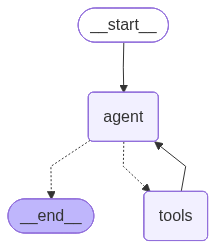

In [58]:
# 🤖 자, 이제 파일 시스템을 다룰 줄 아는 똑똑한 연구원 에이전트를 만들어 봅시다!
# LLM의 두뇌, 파일 도구의 손과 발, 그리고 행동 지침서(프롬프트)를 하나로 합치는 순간입니다.

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from utils import format_messages

from deep_agents_from_scratch.file_tools import ls, read_file, write_file
from deep_agents_from_scratch.state import DeepAgentState

# 📚 웹 검색 결과를 흉내 내는 가짜(mock) 데이터입니다.
search_result = """모델 컨텍스트 프로토콜(MCP)은 Anthropic에서 개발한 오픈 표준 프로토콜이야.
AI 모델과 도구, 데이터베이스, 기타 서비스 같은 외부 시스템을 쉽게 연결할 수 있게 해줘.
표준화된 통신 계층 역할을 하면서 AI 모델이 다양한 소스의 데이터를 일관되고 효율적으로
접근하고 활용할 수 있게 해. 결국 MCP는 데이터 교환을 위한 통합 언어를 제공해서
AI 어시스턴트를 외부 서비스에 연결하는 과정을 단순화해."""


# 🌐 웹 검색 기능을 흉내 내는 가짜(mock) 도구입니다.
@tool(parse_docstring=True)
def web_search(
	query: str,
):
	"""특정 주제에 대한 정보를 웹에서 검색합니다.

	이 도구는 주어진 쿼리에 대한 웹 검색을 수행하고 관련 결과를 반환합니다.
	인터넷에서 어떤 주제에 대한 정보를 수집해야 할 때 사용하세요.

	Args:
		query: 검색 쿼리 문자열. 찾고 있는 정보에 대해 구체적이고 명확하게 작성하세요.

	Returns:
		검색 엔진의 검색 결과.

	Example:
		web_search("헬스케어 분야의 머신러닝 적용 사례")
	"""
	return search_result


# --- 에이전트 구성 요소 정의 ---
# 🧠 모델: 에이전트의 두뇌입니다.
model = init_chat_model(model="google_genai:gemini-2.5-flash", temperature=0.0)
# 🛠️ 도구: 에이전트가 사용할 수 있는 파일 도구와 웹 검색 도구 목록입니다.
tools = [ls, read_file, write_file, web_search]

# ✨ 에이전트 생성!
# `create_react_agent`를 사용하여 모델, 도구, 행동 지침(프롬프트), 그리고 상태 스키마를 결합합니다.
agent = create_react_agent(
	model, tools, prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# 📊 생성된 에이전트의 구조를 시각적으로 확인해봅시다.
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

상태에 `files`가 없고 사용자 연구 요청이 있는 그래프를 시작합니다.

In [59]:
# 🚀 드디어 에이전트에게 실제 임무를 줄 시간입니다!
# "MCP에 대한 개요를 알려줘" 라는 요청을 보내고, 에이전트가 어떻게 파일 시스템을 활용하여
# 이 과제를 해결하는지 관찰해봅시다.

result = agent.invoke(
	{
		# 사용자의 연구 요청
		"messages": [
			{
				"role": "user",
				"content": "Model Context Protocol(MCP)에 대한 개요를 알려줘.",
			}
		],
		# 처음에는 비어있는 파일 시스템으로 시작합니다.
		"files": {},
	}
)
# 에이전트의 전체 작업 흐름과 최종 결과를 출력합니다.
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Model Context Protocol(MCP)에 대한 개요를 알려줘.                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: web_search                                                                                        │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol (MCP) overview"                                                              │
│ }                                                                                                               │
│    ID: 818e0108-58ae-4b50-ab96-fc43ef2f7299                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 모델 컨텍스트 프로토콜(MCP)은 Anthropic에서 개발한 오픈 표준 프로토콜이야.                                      │
│ AI 모델과 도구, 데이터베이스, 기타 서비스 같은 외부 시스템을 쉽게 연결할 수 있게 해줘.                          │
│ 표준화된 통신 계층 역할을 하면서 AI 모델이 다양한 소스의 데이터를 일관되고 효율적으로                           │
│ 접근하고 활용할 수 있게 해. 결국 MCP는 데이터 교환을 위한 통합 언어를 제공해서                                  │
│ AI 어시스턴트를 외부 서비스에 연결하는 과정을 단순화해.                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Model Context Protocol(MCP)은 Anthropic에서 개발한 오픈 표준 프로토콜입니다. 이 프로토콜은 AI 모델과 도구,      │
│ 데이터베이스, 기타 서비스와 같은 외부 시스템 간의 연결을 용이하게 합니다. MCP는 표준화된 통신 계층 역할을 하여  │
│ AI 모델이 다양한 소스의 데이터를 일관되고 효율적으로 접근하고 활용할 수 있도록 합니다. 궁극적으로 MCP는 데이터  │
│ 교환을 위한 통합 언어를 제공하여 AI 어시스턴트를 외부 서비스에 연결하는 과정을 단순화합니다.                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

우리 모의 파일 시스템에 저장된 파일을 확인할 수 있습니다. 

In [60]:
# 📁 에이전트의 작업이 끝난 후, 가상 파일 시스템에 어떤 파일이 남아있는지 확인해봅시다.
# 에이전트가 작업 중에 생성한 파일들을 여기에서 볼 수 있습니다.
result["files"]

{}

Trace: 
https://smith.langchain.com/public/b03e20b4-e908-488d-84a9-8f891d17addd/r
<!-- https://smith.langchain.com/public/1066102f-d7b3-423c-b556-006865a1d479/r -->